In [113]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [114]:
import inspect
def select_df(df, **kwargs):
    attrs = df.attrs
    for k, vs in kwargs.items():
        if vs is None:
            df = df[df.__getitem__(k).isna()]
        elif not isinstance(vs, list):
            df = df[df.__getitem__(k) == vs]
        else:
            df = df[df.__getitem__(k).isin(vs)]
    df.attrs = attrs
    return df


def _augment_df(df, fn, name=None, register=None):
    name = fn.__name__ if name is None else name
    params = list(inspect.signature(fn).parameters.keys())
#     fixed = {p: df.attrs["uniq"][p] for p in params if p not in df.columns}
#     params = [p for p in params if p not in fixed
#     if len(fixed) > 0:
#         fn = functools.partial(fn, **fixed)

    def wrapper(row):
        kwargs = {k: row.get(k) for k in params}
        return fn(**kwargs)

    df[name] = df.apply(wrapper, axis=1)

    if register:
        if not register in df.attrs:
            df.attrs[register] = []
        if name not in df.attrs[register]:
            df.attrs[register].append(name)


def augment_df(df, *fns, register=None):
    for f in fns:
        _augment_df(df, f, register=register)

In [115]:
import pandas as pd
df = pd.read_csv('covid_vaccine_data.csv', index_col=0)
df.date = pd.to_datetime(df.date)
df.iso_code = df.iso_code.astype('category')
df.drop(columns=['source_name', 'source_website'], inplace=True)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15666 entries, 0 to 15665
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   iso_code                             15666 non-null  category      
 1   country                              15666 non-null  object        
 2   date                                 15666 non-null  datetime64[ns]
 3   total_vaccinations                   9437 non-null   float64       
 4   people_vaccinated                    8754 non-null   float64       
 5   people_fully_vaccinated              6502 non-null   float64       
 6   daily_vaccinations                   15465 non-null  float64       
 7   total_vaccinations_per_hundred       9437 non-null   float64       
 8   people_vaccinated_per_hundred        8754 non-null   float64       
 9   people_fully_vaccinated_per_hundred  6502 non-null   float64       
 10  daily_vacc

In [117]:
# Check how much missing data we have
df.isna().mean() * 100

iso_code                                0.000000
country                                 0.000000
date                                    0.000000
total_vaccinations                     39.761266
people_vaccinated                      44.121026
people_fully_vaccinated                58.496106
daily_vaccinations                      1.283033
total_vaccinations_per_hundred         39.761266
people_vaccinated_per_hundred          44.121026
people_fully_vaccinated_per_hundred    58.496106
daily_vaccinations_per_million          1.283033
vaccines                                0.000000
Population                              7.251372
Full_vaccinations(count)               22.137112
Total_vaccinations(count)               1.589429
dtype: float64

In [118]:
# df.groupby('iso_code')['total_vaccinations'].value_counts()

In [119]:
# Columns that are constant within a country
for c in df.columns:
    if all(len(sdf[c].unique()) == 1 for _, sdf in df.groupby('iso_code')):
        print(c)

iso_code
country
vaccines
Population
Full_vaccinations(count)
Total_vaccinations(count)


In [120]:
# Double check that last couple columns are just max of other columns
print((
df.groupby('iso_code')['Full_vaccinations(count)'].mean() - \
df.groupby('iso_code')['people_fully_vaccinated'].max()
).value_counts())

print((
df.groupby('iso_code')['Total_vaccinations(count)'].mean() - \
df.groupby('iso_code')['total_vaccinations'].max()
).value_counts())

0.0    123
dtype: int64
0.0    193
dtype: int64


In [121]:
# Same for last couple cols
assert 0.0 == df.groupby('iso_code')['Full_vaccinations(count)'].std().sort_values(ascending=False).fillna(0).sum()
assert 0.0 == df.groupby('iso_code')['Total_vaccinations(count)'].std().sort_values(ascending=False).fillna(0).sum()

In [122]:
import numpy as np

In [123]:
np.allclose(
    df.total_vaccinations / df.Population * 100,
    df.total_vaccinations_per_hundred,
#     equal_nan=True,
#     atol=np.inf,
#     rtol=100
)

False

In [124]:
# What does the vaccine column look like?
df[df.iso_code=='ESP'].vaccines.value_counts()

Johnson&Johnson, Moderna, Oxford/AstraZeneca, Pfizer/BioNTech    122
Name: vaccines, dtype: int64

In [125]:
df.iso_code.sort_values()

0        ABW
22       ABW
23       ABW
24       ABW
25       ABW
        ... 
15610    ZWE
15609    ZWE
15608    ZWE
15615    ZWE
15665    ZWE
Name: iso_code, Length: 15666, dtype: category
Categories (196, object): ['ABW', 'AFG', 'AGO', 'AIA', ..., 'WSM', 'ZAF', 'ZMB', 'ZWE']

In [126]:
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='iso_code'>

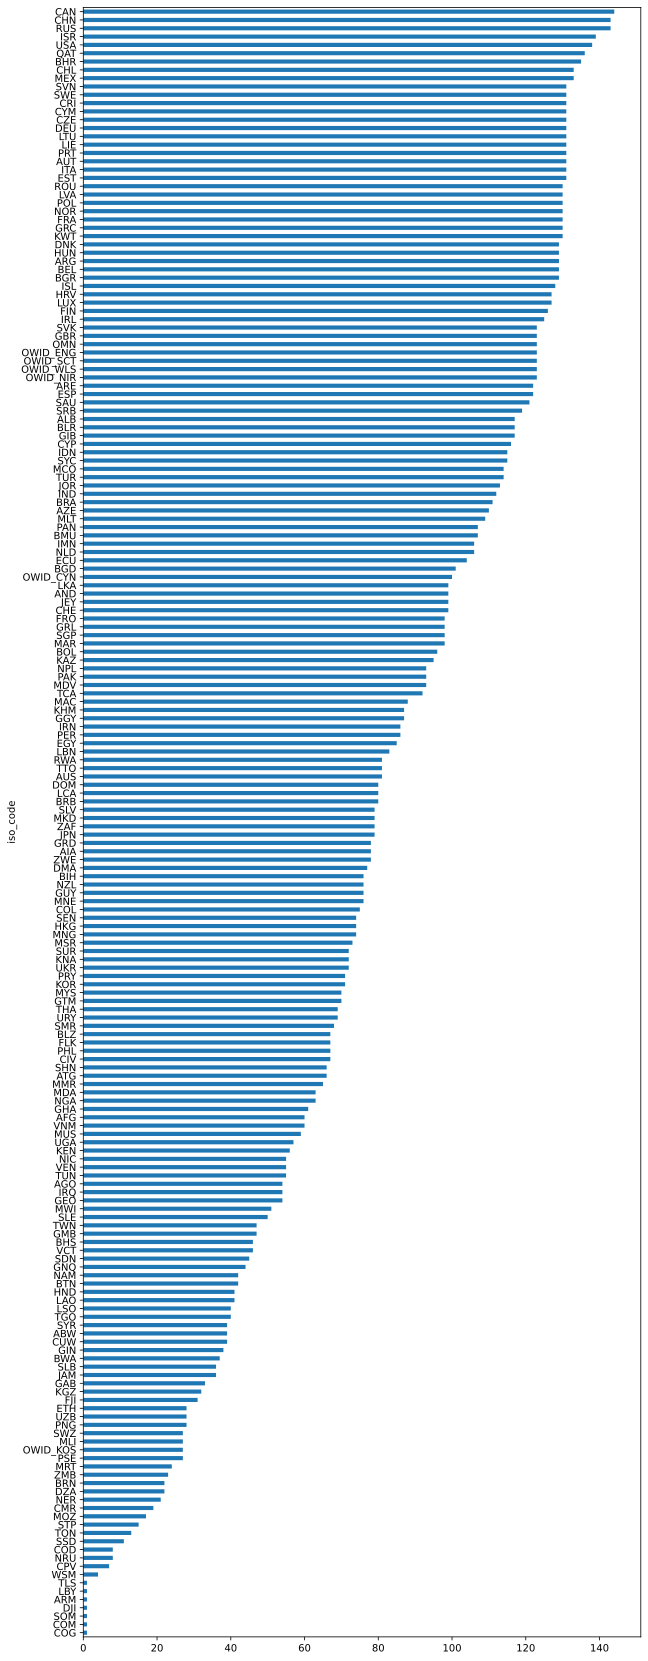

In [127]:
# Look at how much data we have per country
fig, ax = plt.subplots(figsize=(10,30))
df.groupby(by='iso_code').date.count().sort_values(ascending=True).plot(kind='barh', ax=ax)

In [128]:
import seaborn as sns

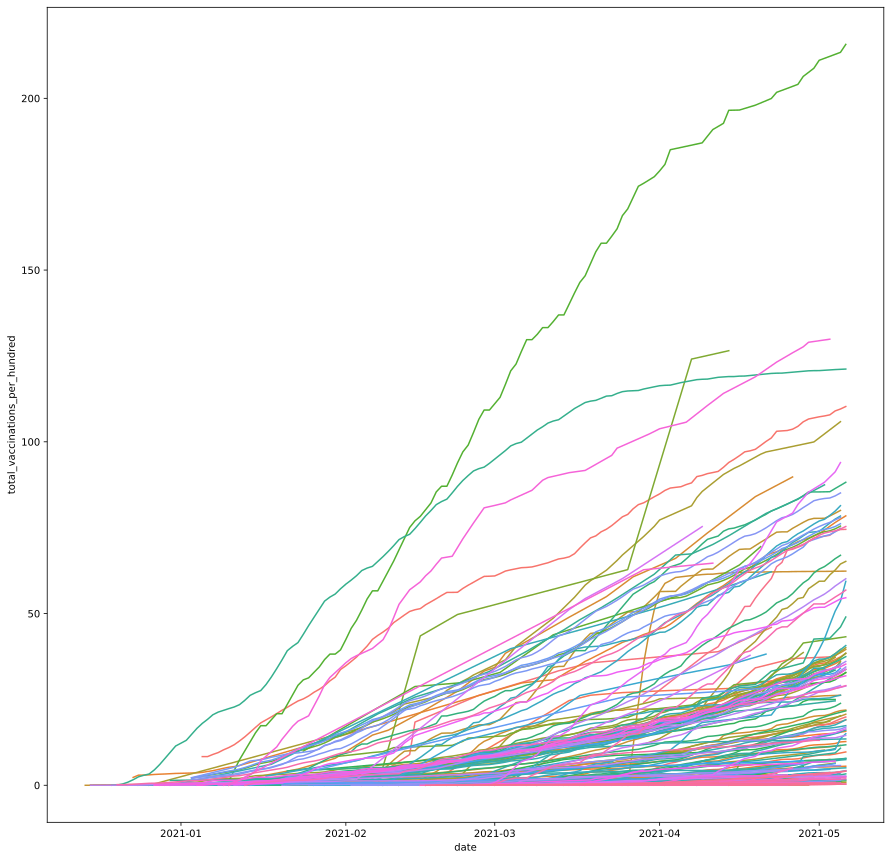

In [129]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.lineplot(
    data=df, 
    x='date',
    y='total_vaccinations_per_hundred',
    hue='iso_code',
    legend=False,
    ax=ax,
)

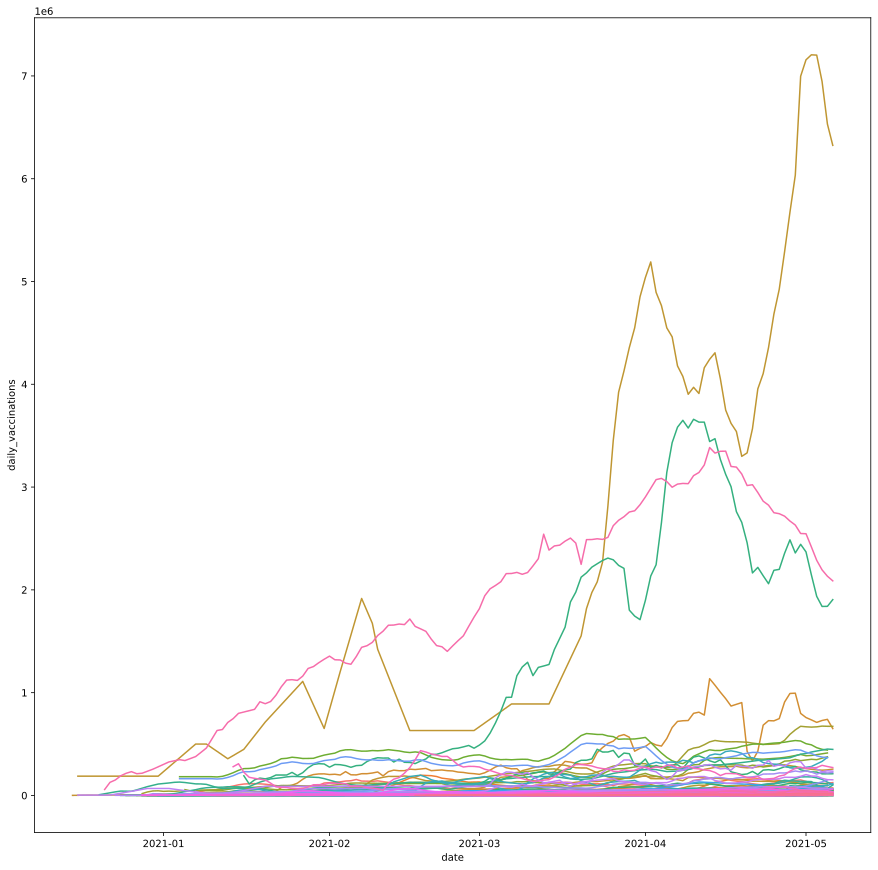

In [130]:
fig, ax = plt.subplots(figsize=(15,15))
g = sns.lineplot(
    data=df, 
    x='date',
    y='daily_vaccinations',
    hue='iso_code',
    legend=False,
    ax=ax,
)

In [131]:
Europe = ['ALB', 'AND', 'AUT', 'BLR', 'BEL', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FRO', 'FIN', 'FRA', 'DEU', 'GIB', 'GRC', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'XKX', 'LVA', 'LIE', 'LTU', 'LUX', 'MKD', 'MLT', 'MDA', 'MCO', 'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SMR', 'SRB', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'UKR', 'GBR', 'VAT', 'RSB']

In [132]:
df['in_europe'] = df.iso_code.isin(Europe)

In [133]:
sdf = df[df.in_europe]
sdf = sdf[sdf.Population > 7e6]
sdf = sdf[sdf.iso_code != 'UKR'] # Ukraine is noisy

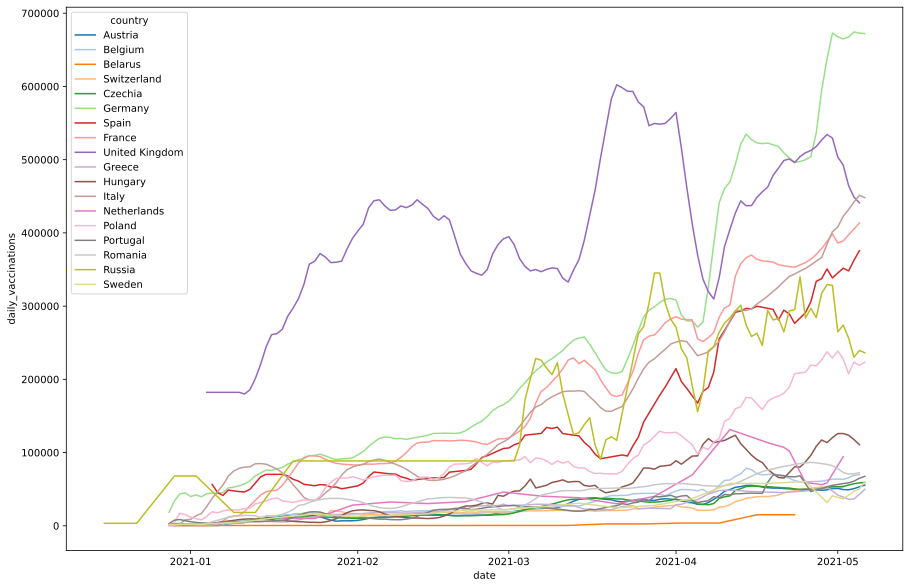

In [134]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf, 
    x='date',
    y='daily_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    markers=True,
    ax=ax,
)

[None]

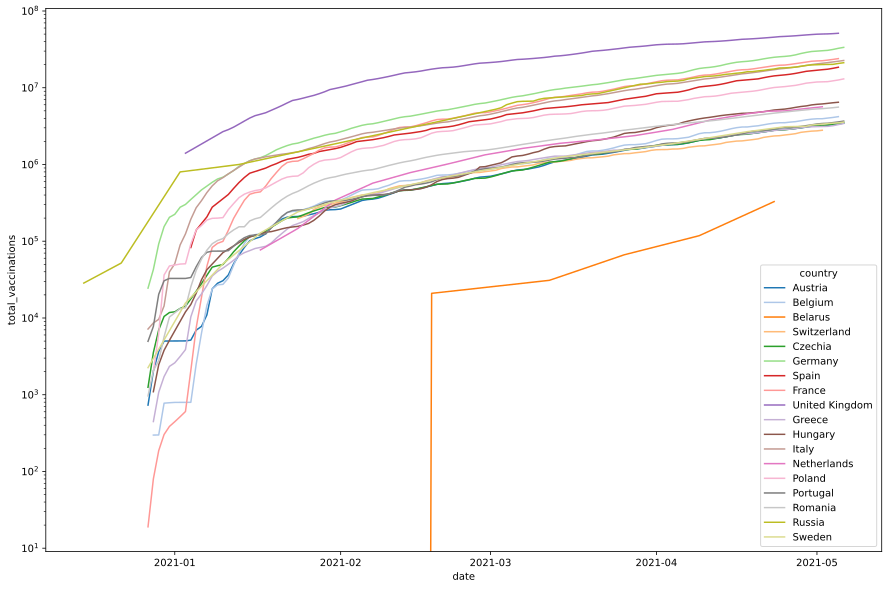

In [135]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf, 
    x='date',
    y='total_vaccinations',
    hue='country',
#     legend=False,
    palette='tab20',
    ax=ax,
)
ax.set(yscale='log')

## ^ Paises europeos grandes (excepto UK) tienen una tendencia exponencial bastante clara.

[None]

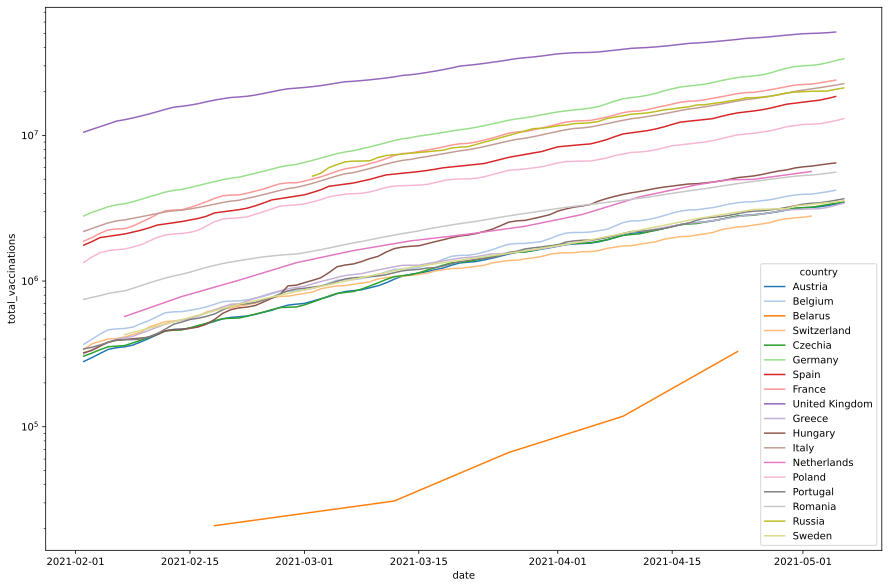

In [136]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='total_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

## ^ Esto pide Linear Regression mas que otra cosa

In [137]:
starting_vaccinations = sdf[sdf.date == '2021-02-01'][['iso_code', 'total_vaccinations']].set_index('iso_code')

In [138]:
def normalized_vaccinations(iso_code, total_vaccinations, Population):
    return (total_vaccinations - starting_vaccinations.loc[iso_code]) / Population
    
augment_df(sdf, normalized_vaccinations)

In [139]:
sdf.country.unique()

array(['Austria', 'Belgium', 'Belarus', 'Switzerland', 'Czechia',
       'Germany', 'Spain', 'France', 'United Kingdom', 'Greece',
       'Hungary', 'Italy', 'Netherlands', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Sweden'], dtype=object)

## Normalizamos por la poblacion y la cantidad a principios de febrero, UK va de por libre, el resto van a un ritmo muy claro

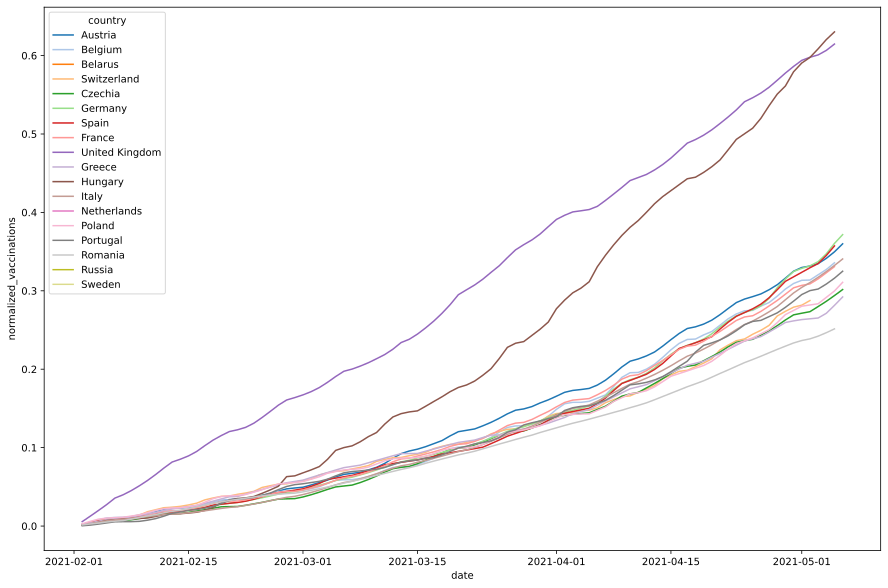

In [140]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
# ax.set(yscale='log')


[None]

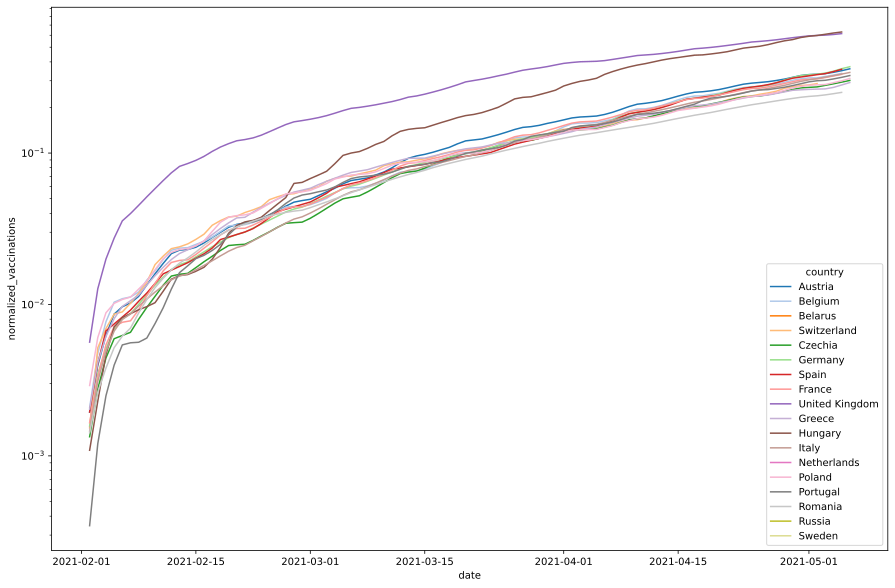

In [141]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=sdf[sdf.date > '2021-02'], 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')

[None]

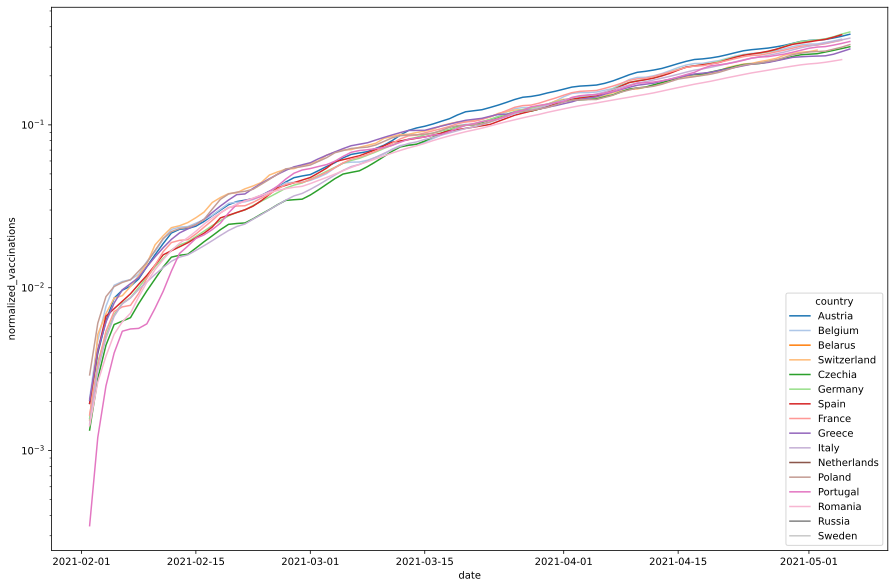

In [142]:
ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]
ssdf = ssdf[ssdf.date > '2021-02']

fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    data=ssdf, 
    x='date',
    y='normalized_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    ax=ax,
)
ax.set(yscale='log')


In [143]:
from datetime import datetime as dt


data = ssdf.copy()
data = data[~data.normalized_vaccinations.isna()]
data = data[data.date > '2021-02']

#x = data.date.map(dt.datetime.toordinal).to_numpy()
x = data.date.map(dt.toordinal).to_numpy()
y = data.normalized_vaccinations.to_numpy()
max_, min_ = np.max(x), np.min(x)
x = (x-min_)/(max_-min_)

In [144]:
from scipy.optimize import curve_fit

def lineal(x, a, b):
    return a*x +b 

def powerlaw(x, a, b, c):
    return c*x**a + b

def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

def exp(x, a, b, c):
    return a**(x-c)+b

def logistic(x, a, b, c, d):
    return a/(1+np.exp(b*(x-c))) + d

funcs = [powerlaw, quadratic, exp, logistic, lineal]



In [145]:
optimal_params = {f:curve_fit(f, x, y) for f in funcs}

# popt, np.sqrt(pcov.diagonal()), np.sqrt(pcov.diagonal())/popt * 100

In [146]:
monokai_cmap =     [
        "#66D9EF",
        "#F92672",
        "#A6E22E",
        "#FD971F",
        "#AE81FF",
        "#ffd866",
        "#DDDDDD",
        "#67a9b5",
        "#d3201f",
        "#47840e",
    ]

<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b
<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b


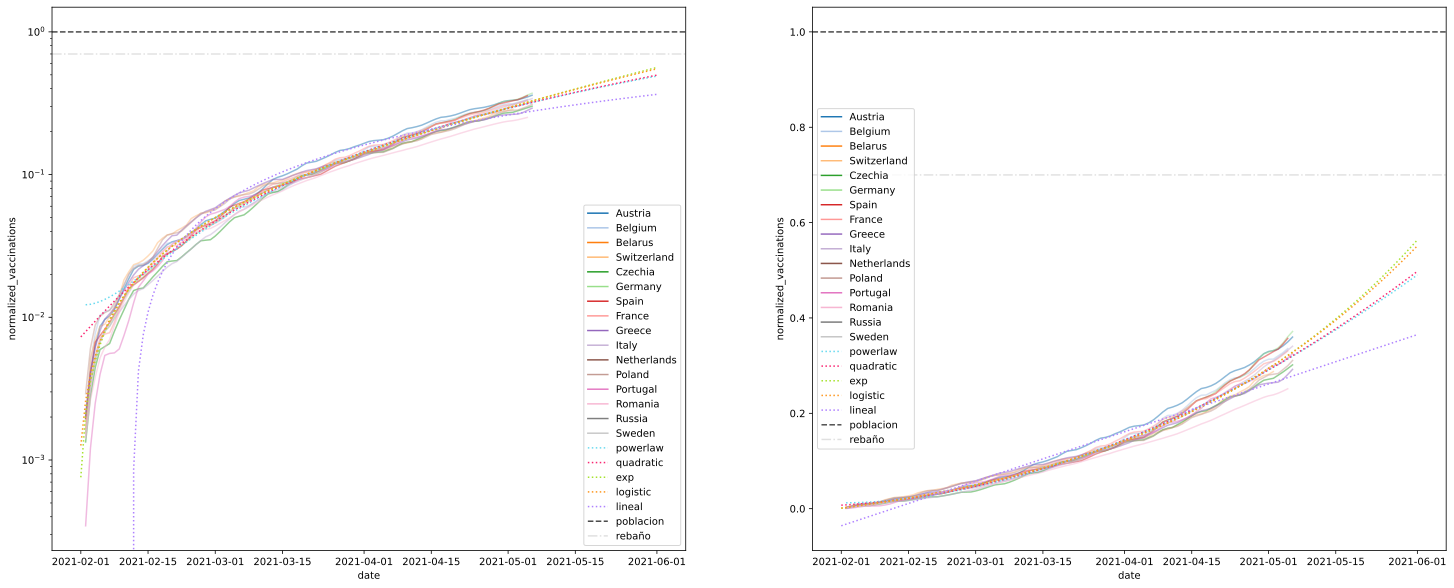

In [147]:
dates = pd.date_range(start='2021-02-01', end='2021-06-01')
#xt = dates.map(dt.datetime.toordinal).to_numpy()
xt = dates.map(dt.toordinal).to_numpy()
xt = (xt-min_)/(max_-min_)

ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, axes = plt.subplots(1, 2, figsize=(25,10))
for i, ax in enumerate(axes):
    g = sns.lineplot(
        data=ssdf[ssdf.date > '2021-02'], 
        x='date',
        y='normalized_vaccinations',
        hue='country',
        palette='tab20',
    #     legend=False,
        alpha=0.5,
        ax=ax,
    )

    if i == 0:
        ax.set(yscale='log')
    for i, f in enumerate(funcs):
        popt, _ = optimal_params[f]
        yt = f(xt, *popt)
        ax.plot(dates, yt, ls=':', label=f.__name__, color=monokai_cmap[i], zorder=100)

    ax.axhline(1, color='black', ls='--', alpha=0.7, label='poblacion')
    ax.axhline(0.7, color='lightgray', ls='-.', alpha=0.7, label='rebaño')
    ax.legend()

<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b
<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b


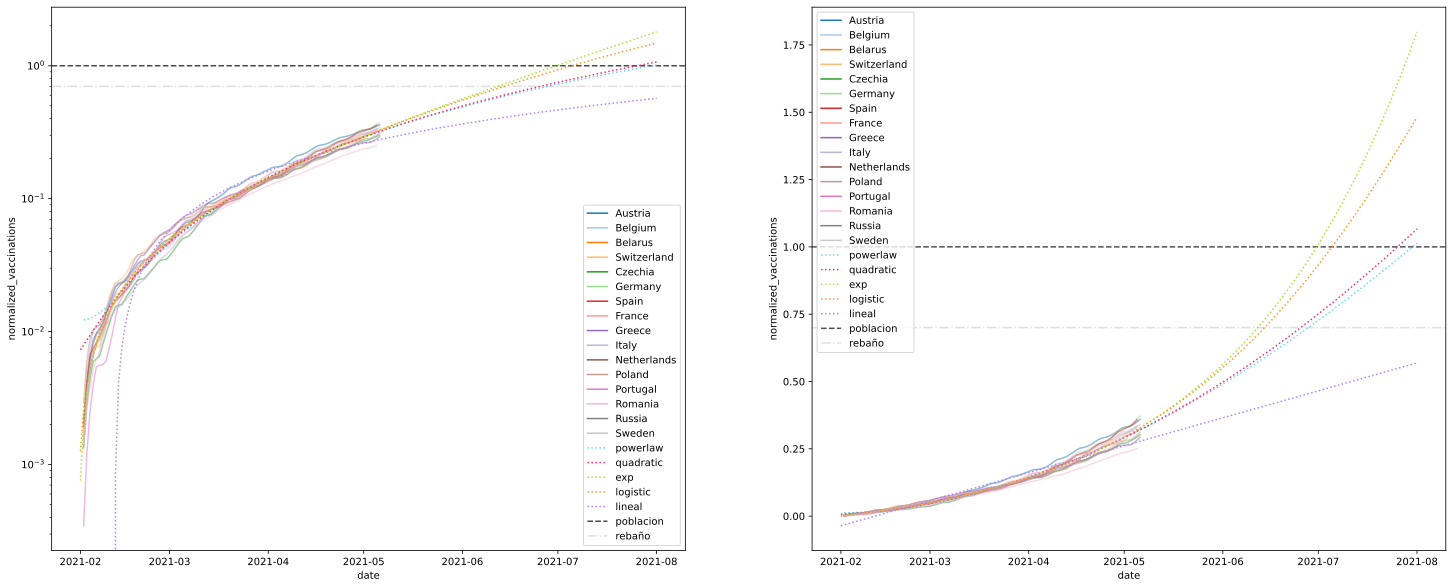

In [148]:
dates = pd.date_range(start='2021-02-01', end='2021-08-01')
#xt = dates.map(dt.datetime.toordinal).to_numpy()
xt = dates.map(dt.toordinal).to_numpy()
xt = (xt-min_)/(max_-min_)

ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, axes = plt.subplots(1, 2, figsize=(25,10))
for i, ax in enumerate(axes):
    g = sns.lineplot(
        data=ssdf[ssdf.date > '2021-02'], 
        x='date',
        y='normalized_vaccinations',
        hue='country',
        palette='tab20',
    #     legend=False,
        alpha=0.5,
        ax=ax,
    )

    if i == 0:
        ax.set(yscale='log')
    for i, f in enumerate(funcs):
        popt, _ = optimal_params[f]
        yt = f(xt, *popt)
        ax.plot(dates, yt, ls=':', label=f.__name__, color=monokai_cmap[i], zorder=100)

    ax.axhline(1, color='black', ls='--', alpha=0.7, label='poblacion')
    ax.axhline(0.7, color='lightgray', ls='-.', alpha=0.7, label='rebaño')
    ax.legend()

In [149]:
groups = data.groupby('date').normalized_vaccinations
dates = groups.mean().index
y_means = groups.mean().to_numpy()
y_spread = groups.std().to_numpy()
#x = dates.map(dt.datetime.toordinal)
x = dates.map(dt.toordinal)
max_, min_ = np.max(x), np.min(x)
x = (x-min_)/(max_-min_)

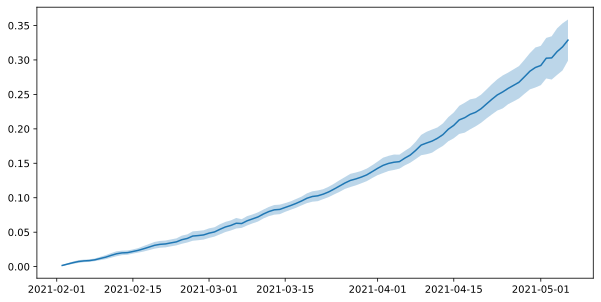

In [150]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, y_means)
ax.fill_between(dates, y_means-y_spread, y_means+y_spread,alpha=0.3)

In [151]:
optimal_params = {f:curve_fit(f, x, y_means, sigma=y_spread, absolute_sigma=True) for f in funcs}

/Users/gema/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b
<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b


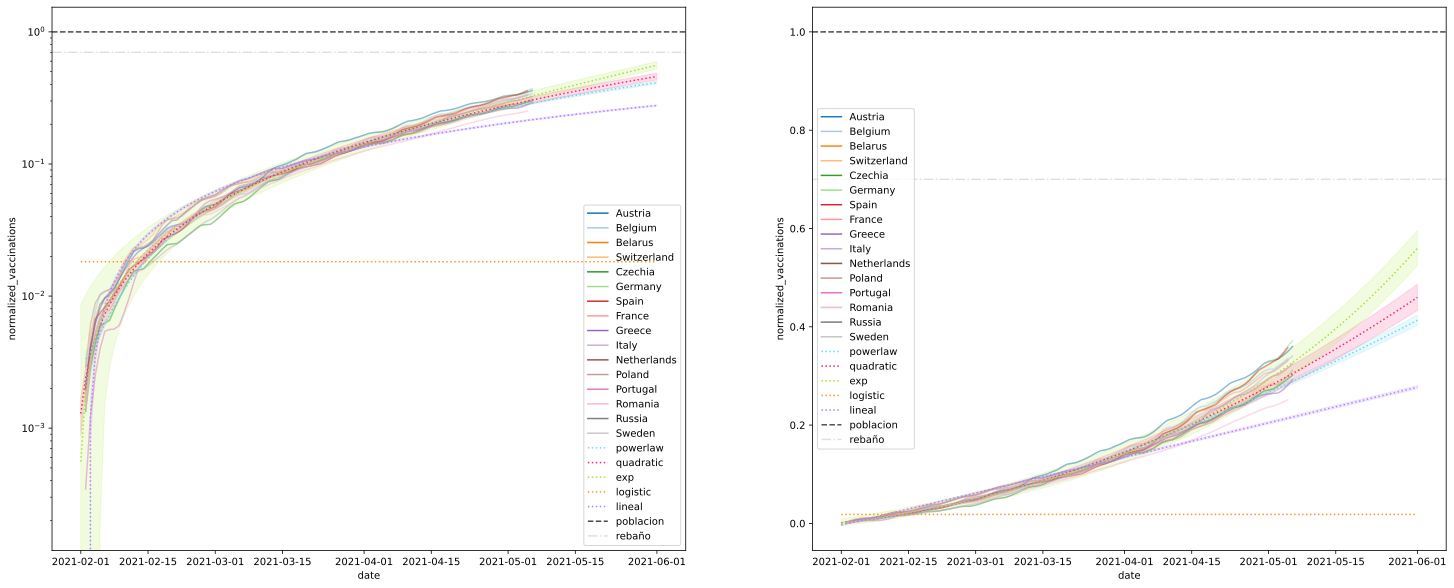

In [152]:
dates = pd.date_range(start='2021-02-01', end='2021-06-01')
#xt = dates.map(dt.datetime.toordinal).to_numpy()
xt = dates.map(dt.toordinal).to_numpy()
xt = (xt-min_)/(max_-min_)

ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, axes = plt.subplots(1, 2, figsize=(25,10))
for i, ax in enumerate(axes):
    g = sns.lineplot(
        data=ssdf[ssdf.date > '2021-02'], 
        x='date',
        y='normalized_vaccinations',
        hue='country',
        palette='tab20',
    #     legend=False,
        alpha=0.5,
        ax=ax,
    )

    if i == 0:
        ax.set(yscale='log')
    for i, f in enumerate(funcs):
        popt, pcov = optimal_params[f]
        sigma = np.sqrt(pcov.diagonal())
        yt = f(xt, *popt)
        bound_upper = f(xt, *(popt+sigma))
        bound_lower = f(xt, *(popt-sigma))
        ax.plot(dates, yt, ls=':', label=f.__name__, color=monokai_cmap[i], zorder=100)
        ax.fill_between(dates, bound_lower, bound_upper, alpha=0.15, color=monokai_cmap[i])
        ax.plot()

    ax.axhline(1, color='black', ls='--', alpha=0.7, label='poblacion')
    ax.axhline(0.7, color='lightgray', ls='-.', alpha=0.7, label='rebaño')
    ax.legend()

<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b
<ipython-input-144-fdd863ba1cd5>:7: RuntimeWarning: invalid value encountered in power
  return c*x**a + b


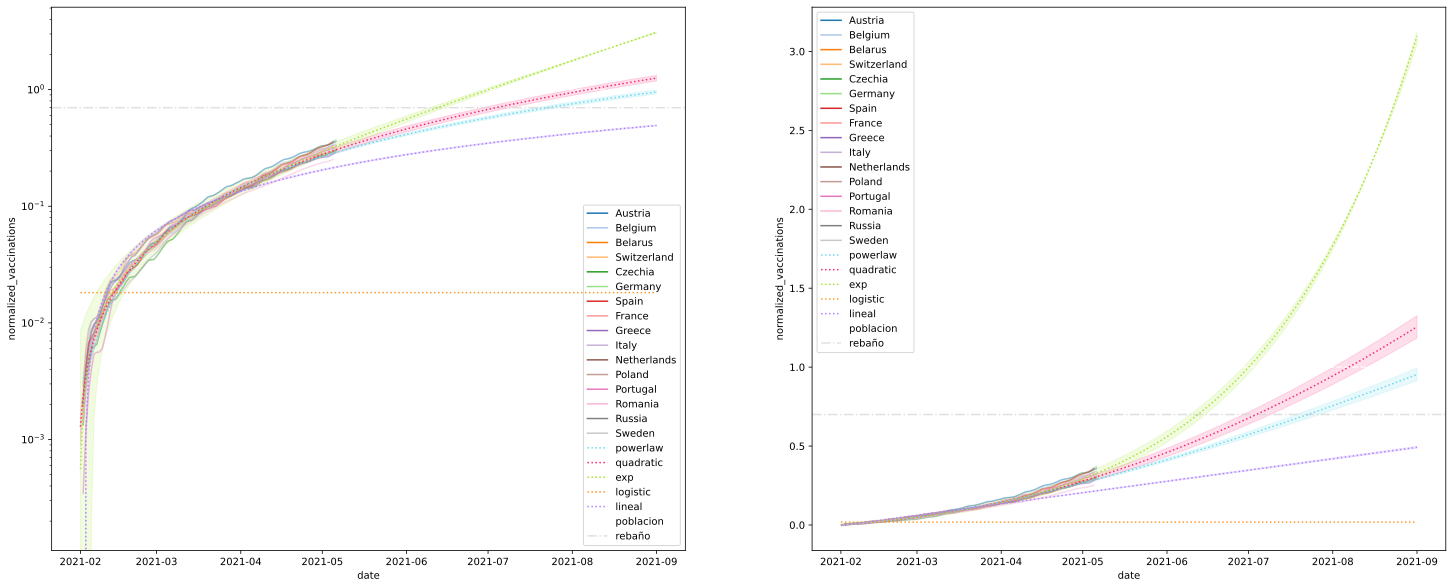

In [153]:
dates = pd.date_range(start='2021-02-01', end='2021-09-01')
#xt = dates.map(dt.datetime.toordinal).to_numpy()
xt = dates.map(dt.toordinal).to_numpy()
xt = (xt-min_)/(max_-min_)

ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


fig, axes = plt.subplots(1, 2, figsize=(25,10))
for i, ax in enumerate(axes):
    g = sns.lineplot(
        data=ssdf[ssdf.date > '2021-02'], 
        x='date',
        y='normalized_vaccinations',
        hue='country',
        palette='tab20',
    #     legend=False,
        alpha=0.5,
        ax=ax,
    )

    if i == 0:
        ax.set(yscale='log')
    for i, f in enumerate(funcs):
        popt, pcov = optimal_params[f]
        sigma = np.sqrt(pcov.diagonal())
        yt = f(xt, *popt)
        bound_upper = f(xt, *(popt+sigma))
        bound_lower = f(xt, *(popt-sigma))
        ax.plot(dates, yt, ls=':', label=f.__name__, color=monokai_cmap[i], zorder=100)
        ax.fill_between(dates, bound_lower, bound_upper, alpha=0.15, color=monokai_cmap[i])
        ax.plot()

    ax.axhline(1, color='white', ls='--', alpha=0.7, label='poblacion')
    ax.axhline(0.7, color='lightgray', ls='-.', alpha=0.7, label='rebaño')
    ax.legend()

In [154]:
# ssdf = sdf[~sdf.iso_code.isin(['GBR', 'HUN'])]


# fig, ax = plt.subplots(figsize=(15,10))
# g = sns.lineplot(
#     data=ssdf[ssdf.date > '2021-02'], 
#     x='date',
#     y='normalized_vaccinations',
#     hue='country',
#     palette='tab20',
# #     legend=False,
#     ax=ax,
# )
# # ax.set(yscale='log')

# ax.plot(dates, np.exp(yt), ls=':')

In [155]:
# Esto es 

In [156]:
# # min_total = sdf.groupby('iso_code').agg({'total_vaccinations': lambda g: g.min(skipna=True)}).fillna(0)
# # min_total.rename(columns={'total_vaccinations': 'min_existing'}, inplace=True)
# # min_total = pd.merge(min_total, sdf, on='iso_code')['min_existing']

# sdf['total_from_daily'] = sdf.groupby('iso_code').daily_vaccinations.cumsum()

# fig, ax = plt.subplots(figsize=(15,10))
# g = sns.lineplot(
#     data=sdf, 
#     x='date',
#     y='total_from_daily',
#     hue='country',
# #     legend=False,
#     ax=ax,
# )
# ax.set(yscale='log')

# sdf['daily_error'] = sdf['total_from_daily'] - sdf['total_vaccinations']

# fig, ax = plt.subplots(figsize=(15,10))
# g = sns.lineplot(
#     data=sdf, 
#     x='date',
#     y='daily_error',
#     hue='country',
# #     legend=False,
#     ax=ax,
# )
# # ax.set(yscale='log')

In [157]:
sdf

,iso_code,country,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,Population,Full_vaccinations(count),Total_vaccinations(count),in_europe,normalized_vaccinations
846,AUT,Austria,2020-12-27,732.0,732.0,NaN,NaN,0.01,0.01,NaN,NaN,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",8877067.0,925062.0,3458063.0,True,-0.029548
847,AUT,Austria,2020-12-28,2033.0,2033.0,NaN,1301.0,0.02,0.02,NaN,144.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",8877067.0,925062.0,3458063.0,True,-0.029401
848,AUT,Austria,2020-12-29,3652.0,3652.0,NaN,1460.0,0.04,0.04,NaN,162.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",8877067.0,925062.0,3458063.0,True,-0.029219
849,AUT,Austria,2020-12-30,5004.0,5004.0,NaN,1424.0,0.06,0.06,NaN,158.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",8877067.0,925062.0,3458063.0,True,-0.029066
850,AUT,Austria,2020-12-31,5012.0,5012.0,NaN,1070.0,0.06,0.06,NaN,119.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",8877067.0,925062.0,3458063.0,True,-0.029065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14259,SWE,Sweden,2021-05-02,NaN,NaN,NaN,36760.0,NaN,NaN,NaN,3640.0,"Oxford/AstraZeneca, Pfizer/BioNTech",10285453.0,794198.0,3563609.0,True,NaN
14260,SWE,Sweden,2021-05-03,NaN,NaN,NaN,41873.0,NaN,NaN,NaN,4146.0,"Oxford/AstraZeneca, Pfizer/BioNTech",10285453.0,794198.0,3563609.0,True,NaN
14261,SWE,Sweden,2021-05-04,3451239.0,2681307.0,769932.0,46986.0,34.17,26.55,7.62,4652.0,"Oxford/AstraZeneca, Pfizer/BioNTech",10285453.0,794198.0,3563609.0,True,NaN
14262,SWE,Sweden,2021-05-05,3485725.0,2710287.0,775438.0,50441.0,34.51,26.84,7.68,4995.0,"Oxford/AstraZeneca, Pfizer/BioNTech",10285453.0,794198.0,3563609.0,True,NaN


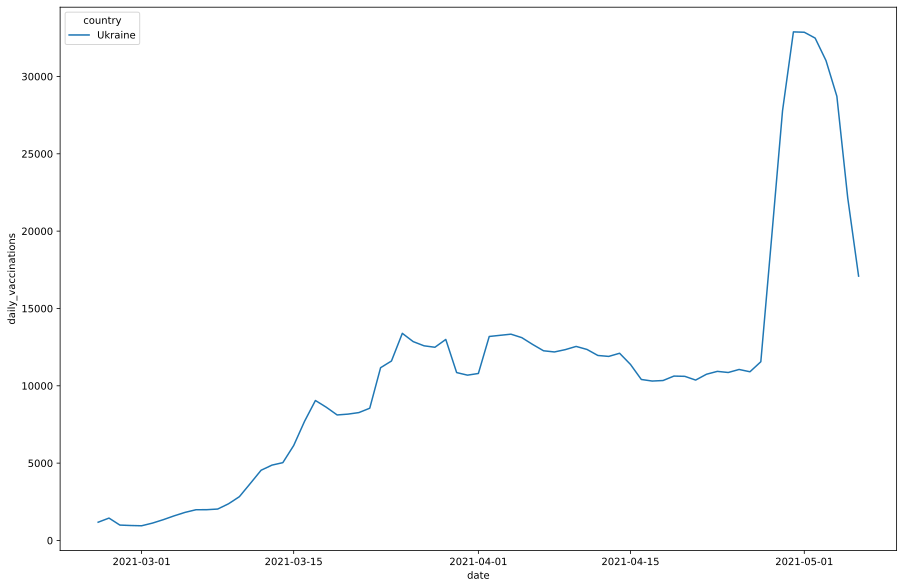

In [158]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    #data=sdf.country(country=='Austria'),
    data = df[df.country == 'Ukraine'],
    x='date',
    y='daily_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    markers=True,
    ax=ax,
)

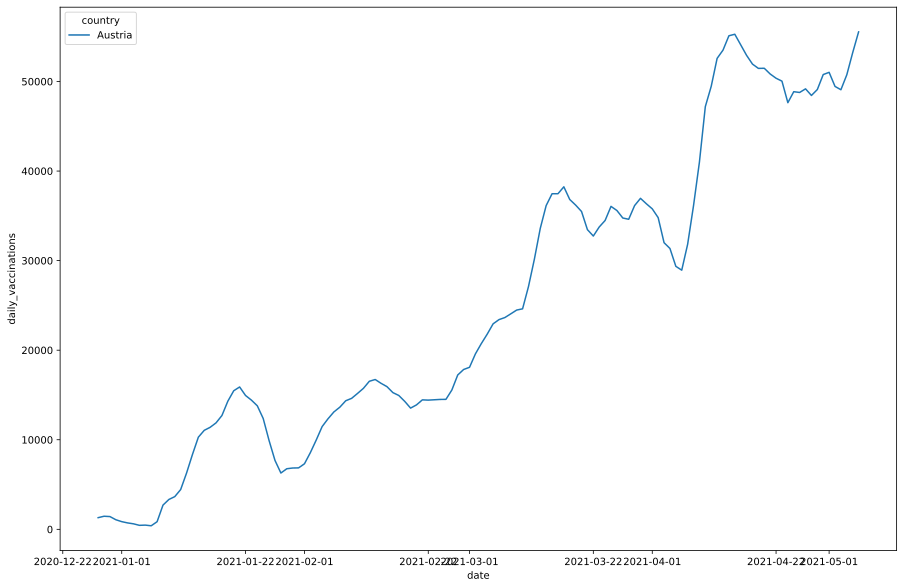

In [159]:
fig, ax = plt.subplots(figsize=(15,10))
g = sns.lineplot(
    #data=sdf.country(country=='Austria'),
    data = sdf[sdf.country == 'Austria'],
    x='date',
    y='daily_vaccinations',
    hue='country',
    palette='tab20',
#     legend=False,
    markers=True,
    ax=ax,
)

In [160]:
#vals = sdf.select(country='Austria').daily_vaccinations.interpolate(method='cubicspline')
vals = sdf[sdf.country == 'Austria'].daily_vaccinations.interpolate(method='cubicspline')


In [161]:
y = vals[~vals.isna()]

In [162]:
z = y - np.linspace(y.min(), y.max(), len(y))

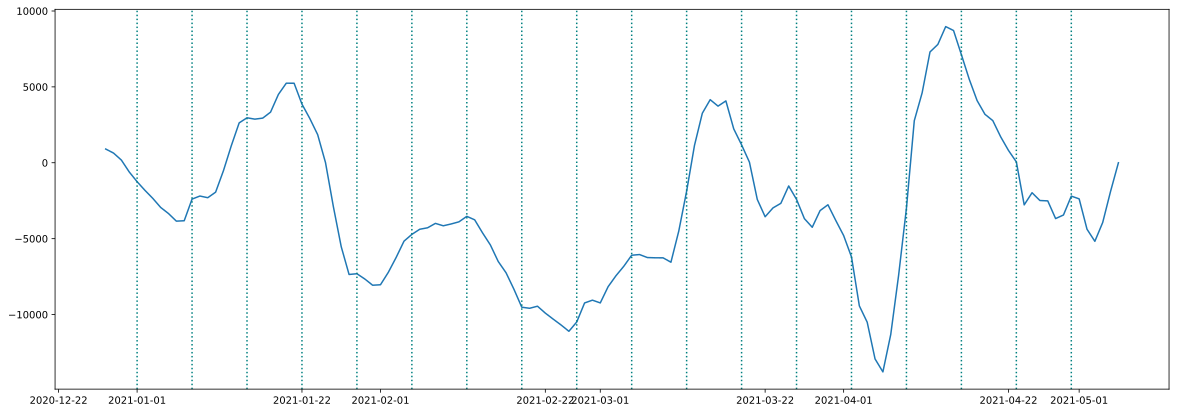

In [163]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(sdf[sdf.country == 'Austria'].date[~vals.isna()], z)
for d in pd.date_range('2021-01-01', '2021-05-01', freq='7d'):
    ax.axvline(d, color='teal', ls=':')